In [1]:
import os
import sys
import random
import math
import numpy as np
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import IPython.display
import colorsys

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# Download this file and place in the root of your 
# project (See README file for details)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.print()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

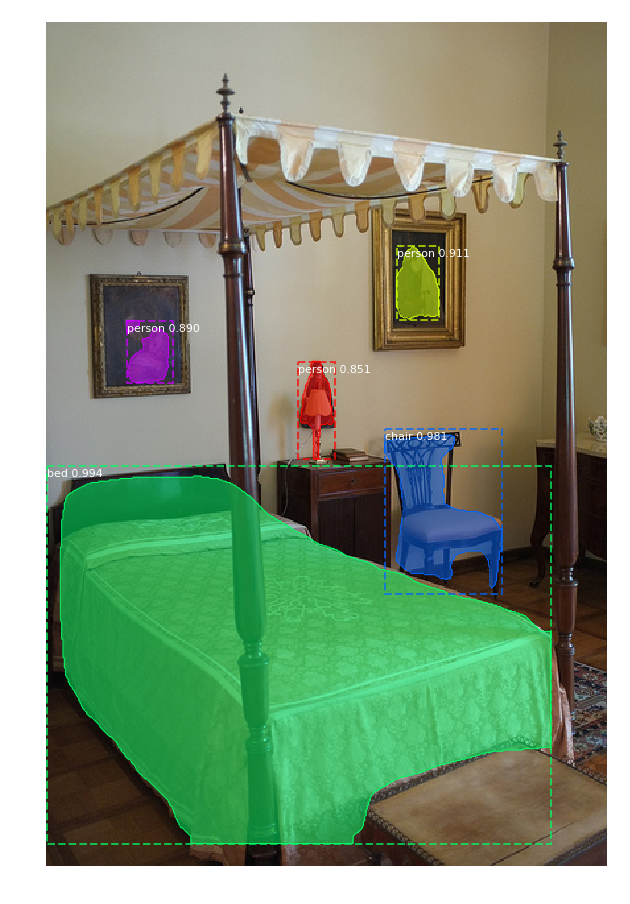

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = scipy.misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=0)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [6]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [9]:
def process_image(image, title="", figsize=(16, 16), ax=None):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes
    results = model.detect([image], verbose=0)
    r = results[0]
    
    boxes = r['rois']
    class_ids = r['class_ids']
    scores = r['scores']
    
    N = boxes.shape[0]

    # Show area outside image boundaries.
    font = cv2.FONT_HERSHEY_DUPLEX
    
    for i in range(N):
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        
        if label == "car":
            y1, x1, y2, x2 = boxes[i]
            #cv2.rectangle(frame, (face_rect.left(),face_rect.top()), (face_rect.right(), face_rect.bottom()), (255,0,0), 3)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 3)
            
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
            cv2.putText(image, caption, (x1 + 6, y2 - 6), font, 0.5, (255, 255, 255), 1)
        
    return image

In [10]:
white_output1 = 'cars_out.mp4'
clip1 = VideoFileClip("cars.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output1, audio=False, bitrate="5000k")

[MoviePy] >>>> Building video cars_out.mp4
[MoviePy] Writing video cars_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:34<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: cars_out.mp4 

Wall time: 10min 34s


In [13]:
HTML("""
     <video width="640" height="360" controls><source src="{0}" type="video/mp4">
     </video>
""".format(white_output1))

Interesting how between 40 to 42 seconds of the video even the a reflection of a car is detected.